In this dataset, each entry represents a person who takes a credit by a bank. Each person is classified as good or bad (Risk == target variable) credit risk according to a set of attributes.

In [1]:
import sys
print(sys.executable)

C:\Python310\python.exe


In [2]:
import pandas as pd
import numpy as np
import joblib
import time
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import seaborn as sns; sns.set()

from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.metrics import make_scorer, RocCurveDisplay, roc_auc_score, recall_score, accuracy_score

from imblearn.metrics import specificity_score

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
from scipy.stats import randint

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

# Make sure that we can see all columns in the ouputs
#pd.set_option('display.max_columns', 65)

# Data Preparation and Data Exploration

In [3]:
# Start by loading the data and displaying the top 5 rows
credit = pd.read_csv("credit_risk.csv", header=0, delimiter=";")
credit.head()

,age,sex,housing,job,savings_account,checking_account,credit_amount,duration,purpose,risk
0,67,male,own,3,NaN,little,1169,6,television,good
1,22,female,own,3,little,moderate,5951,48,television,bad
2,49,male,own,2,little,NaN,2096,12,education,good
3,45,male,free,3,little,little,7882,42,furniture,good
4,53,male,free,3,little,little,4870,24,car,bad


In [4]:
# Display some extra information and descriptive statistics
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   age               1000 non-null   int64 
 1   sex               1000 non-null   object
 2   housing           1000 non-null   object
 3   job               1000 non-null   int64 
 4   savings_account   817 non-null    object
 5   checking_account  606 non-null    object
 6   credit_amount     1000 non-null   int64 
 7   duration          1000 non-null   int64 
 8   purpose           1000 non-null   object
 9   risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.2+ KB


In [5]:
credit.describe()

,age,job,credit_amount,duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,2.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,1.000000,250.000000,4.000000
25%,27.000000,3.000000,1365.500000,12.000000
50%,33.000000,3.000000,2319.500000,18.000000
75%,42.000000,3.000000,3972.250000,24.000000
max,75.000000,4.000000,18424.000000,72.000000


- Half of the loans should be paid back within 18 months.
- The average age is around 36 years.

In [6]:
# Calculate the number of unique values in each column
credit.nunique()

age                  53
sex                   2
housing               3
job                   4
savings_account       4
checking_account      3
credit_amount       921
duration             33
purpose               8
risk                  2
dtype: int64

* Only duration, credit_amount and age have more than 10 unique values.

In [7]:
# Clean up column names
credit.columns = credit.columns.str.strip()

### Numerical Variables

plot the distribution of the numerical variables: duration, credit_amount and age.

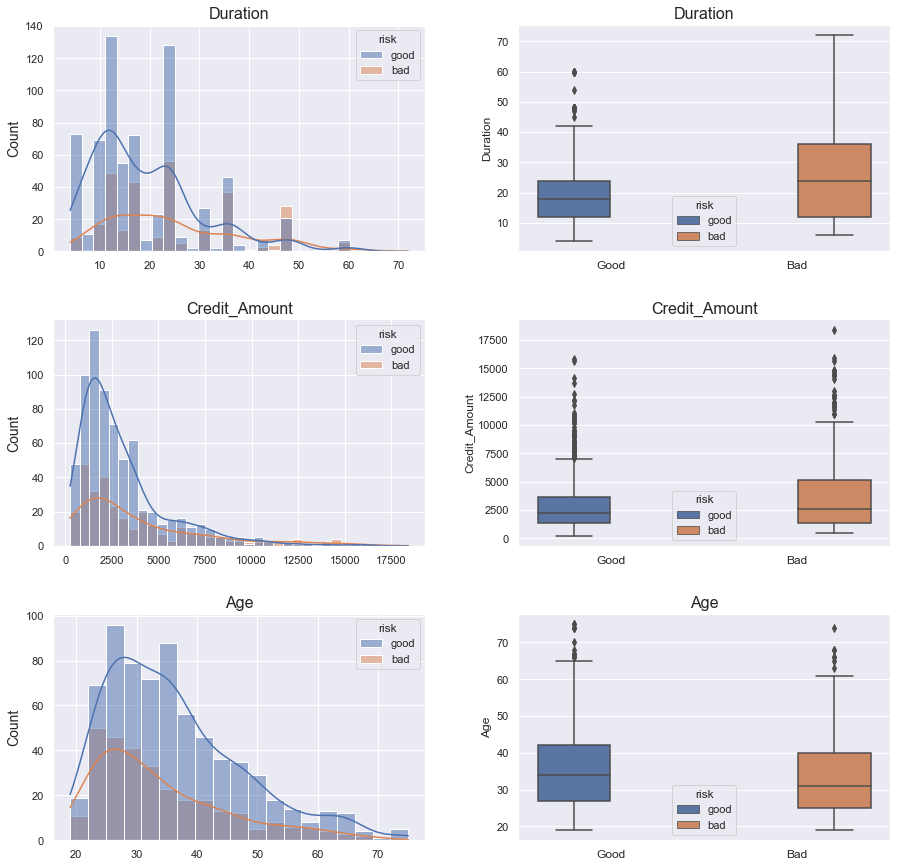

In [8]:
# Select numerical variables
numerical = ['duration', 'credit_amount', 'age']

# Specify plot size and loop over each variable
plt.figure(figsize=(15, 15))
i = 1
for col in numerical:   
    # Plot the data using histograms, split by class
    plt.subplot(3, 2, i)
    sns.histplot(x=col, data=credit, hue='risk', kde=True)
    plt.title(col.title(), size=16)
    plt.xlabel("")
    plt.ylabel("Count", size=14)
    
    # Plot the data using Boxplots
    plt.subplot(3, 2, i+1)
    ax = sns.boxplot(x='risk', y=col, data=credit, hue='risk')
    ax.set_xticklabels(["Good", "Bad"], size=12)
    plt.title(col.title(), size=16)
    plt.ylabel(col.title(), size=12)
    plt.xlabel("")
    
    i += 2
    
plt.subplots_adjust(hspace=0.3, wspace=0.25)

* The median duration for bad credit risk is slightly higher than for good credit risk.

In [9]:
# Test Normality with Shapiro-Wilk Test
print("Duration:")
print(stats.shapiro(credit["duration"]))

print("\nCredit Amount:")
print(stats.shapiro(credit["credit_amount"]))

print("\nAge:")
print(stats.shapiro(credit["age"]))

Duration:
ShapiroResult(statistic=0.8997892737388611, pvalue=4.908141189598946e-25)

Credit Amount:
ShapiroResult(statistic=0.7933971881866455, pvalue=8.609912964372653e-34)

Age:
ShapiroResult(statistic=0.9174707531929016, pvalue=6.381270673909361e-23)


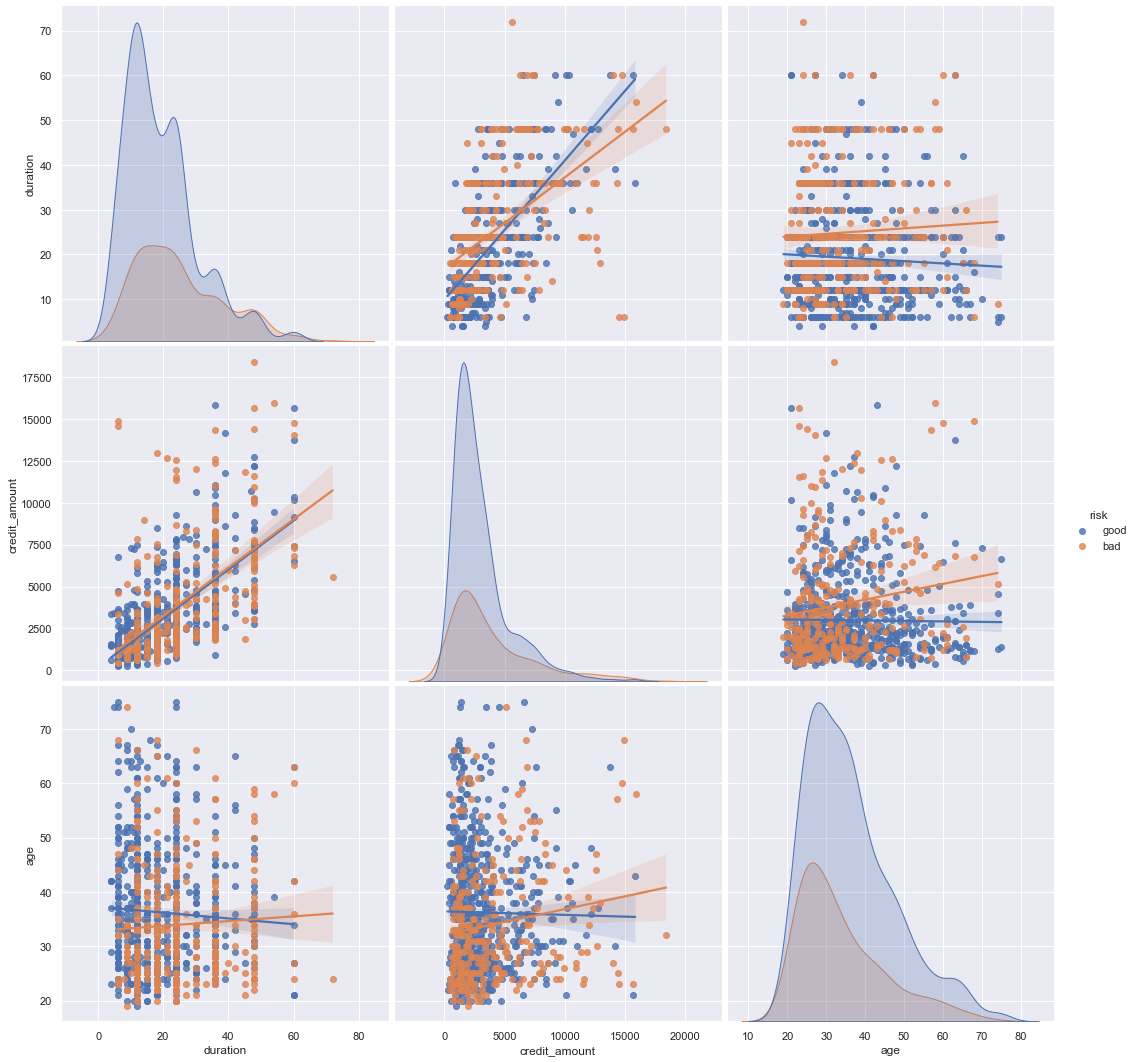

In [10]:
# Plot numerical variables against each other
sns.pairplot(credit[numerical+["risk"]], hue="risk", 
             kind='reg', height=5);

### Categorical Variables

columns installment_commitment, residence_since, existing_credits and num_dependents are all discrete ordinal variables, meaning that there is a natural ordering of the values. As for the purpose of visualisation, we can plot them using the same approach as the categorical variables.

Other columns, such as checking_status and employment probably possess similar characteristics, but they already count as categorical.

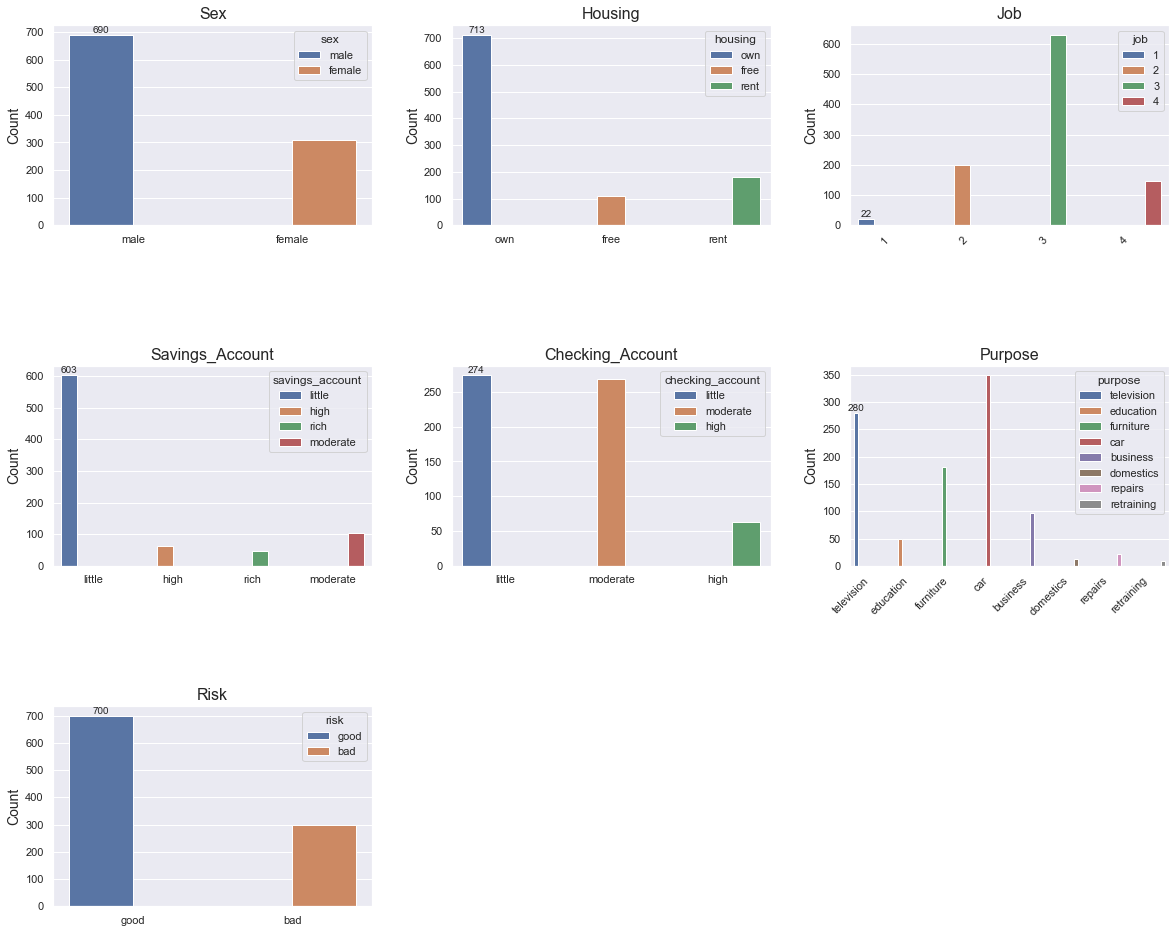

In [11]:
# Select categorical variables
categorical = [col for col in credit.columns if col not in numerical]

plt.figure(figsize=(20, 35))
for i, col in enumerate(credit[categorical], 1):
    
    # Plot corresponding variable
    plt.subplot(6, 3, i)
    ax = sns.countplot(x=col, data=credit, hue=col)
    
    # Adjust labels and title. Display each class count
    plt.xlabel("")
    plt.ylabel("Count", size=14)
    plt.title(col.title(), size=16)
    ax.bar_label(ax.containers[0])
    
    # Rotate long class names in some columns to make them easier to read
    if col in ['credit_history', 'purpose', 'job']:
        plt.xticks(rotation=45, horizontalalignment='right')
        
plt.subplots_adjust(hspace=0.7, wspace=0.25)

### Split the Data

In [12]:
# Split the data into development and test sets
credit_dev, credit_test = train_test_split(credit, test_size=0.2, random_state=89, stratify=credit['risk'])

# Save files for later
credit_dev.to_csv('datasets/cleaned/credit_train.csv', index=False)
credit_test.to_csv('datasets/cleaned/credit_test.csv', index=False)

In [58]:
credit_dev.head()

,risk,age,sex,housing,job,savings_account,checking_account,credit_amount,duration,purpose
289,1,48,1,1,1,1,1,1024,24,1
13,1,60,1,1,2,1,1,1199,24,2
806,2,26,1,1,2,1,2,590,6,1
9,1,28,1,1,3,1,2,5234,30,2
841,2,28,1,1,2,1,3,2993,21,2


In [13]:
# Reorder columns so the target variable is at the first position
cols = list(credit_dev.columns)
cols.remove('risk')
cols.insert(0, 'risk')
credit_dev = credit_dev[cols]

# Randomly shuffle the data to minimise the effect of randomness on our results
credit_enc = credit_dev.sample(frac=1.0, random_state=55)

In [14]:
# Select all categorical columns
# categorical = credit_enc.select_dtypes(include=['object']).columns
categorical_columns = [c for c in credit_enc.columns if c not in numerical]

# Imputar valores faltantes con la moda
imputer = SimpleImputer(strategy='most_frequent')
credit_enc[categorical_columns] = imputer.fit_transform(credit_enc[categorical_columns])

# Define encoder. As we are dealing with categorical variables, make sure that the output are integers
oe = OrdinalEncoder(dtype=np.int64)

# Transform the categorical columns
credit_enc[categorical_columns] = oe.fit_transform(credit_enc[categorical_columns])

# Verify that it looks as expected
credit_enc.head()

,risk,age,sex,housing,job,savings_account,checking_account,credit_amount,duration,purpose
832,0,29,1,2,2,1,1,11816,45,0
21,1,44,1,2,2,0,1,2647,6,7
563,0,37,1,0,2,1,2,12389,36,1
394,1,31,1,1,3,1,1,2406,9,4
261,1,55,0,1,2,1,1,1603,24,7


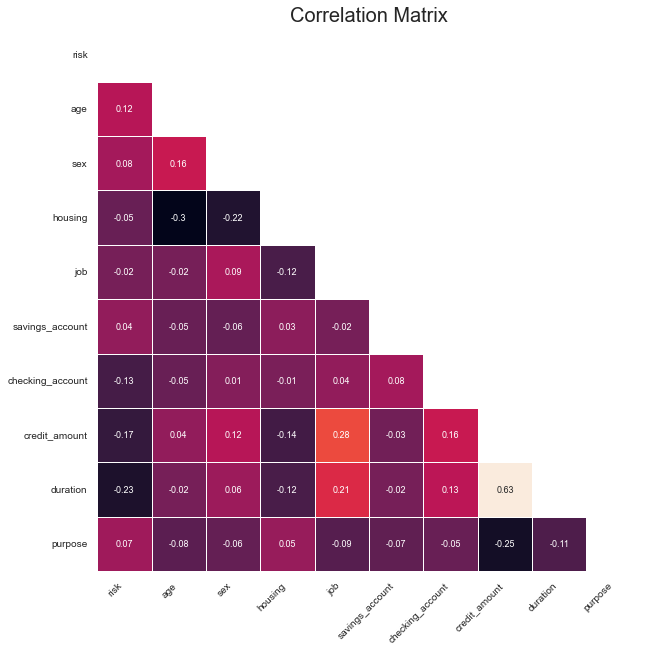

In [15]:
# Calculate correlation matrix
corr = credit_enc.corr()

# Create mask to remove the mirrored diagonal of the matrix
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Plot correlation matrix
plt.figure(figsize=(10, 10))
with sns.axes_style("white"):
    sns.heatmap(np.round(corr, 2), square=True,  annot=True,  
                cbar=False,  linewidth=.5, mask=mask, annot_kws={"size": 9})
    
plt.title("Correlation Matrix", size=20)
plt.xticks(size=10, rotation=45, horizontalalignment='right')
plt.yticks(size=10);

In [16]:
# Select features and target variable
X = credit_enc[credit_enc.columns.difference(['risk'])]
Y = credit_enc['risk']

# Split into train and test sets. 
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, random_state=89, stratify=Y)
trainX.head()

,age,checking_account,credit_amount,duration,housing,job,purpose,savings_account,sex
783,23,2,836,12,1,1,1,2,0
568,41,2,3979,48,1,2,7,1,1
980,49,2,8386,30,1,2,4,1,1
833,42,2,5084,24,1,2,7,1,0
234,42,1,1544,4,1,1,7,1,1


In [69]:
# Save train X file
trainX.to_csv('datasets/cleaned/trainX.csv', index=False)

# Model the Credit Risk

### Logistic Regression

In [19]:
%%time

# Define specificity_score
specificity_scorer = make_scorer(specificity_score, average="weighted")

# Specify scoring metrics
scoring = {
    "auc": make_scorer(roc_auc_score, needs_proba=True),
    "specificity": specificity_scorer,
    "recall": make_scorer(recall_score),
    "accuracy": make_scorer(accuracy_score),
}

# Specify model and subsequent hyperparameters to tune
lr = LogisticRegression(max_iter=100000)
parameters = {
    'clf__C': loguniform(1e-3, 1e+2),  # Use loguniform distribution for C
}

# Create final pipeline
pipeline = Pipeline(steps=([('scaler', StandardScaler()),
                            ('clf', lr)]))

# Perform hyperparameter tuning with RandomizedSearchCV over 10 folds with AUC as refit metric.
rs_lr = RandomizedSearchCV(pipeline, parameters, cv=10, scoring=scoring, refit="auc", random_state=500, n_iter=10)

# Fit the RandomizedSearchCV object to the train data in order to make predictions with the best model later
rs_lr.fit(trainX, trainY)

# Run nested cross-validation over 10 folds
lr_scores = cross_validate(rs_lr, X, Y, cv=10, n_jobs=-1, verbose=1,
                        return_train_score=True, scoring=scoring)

# Make cross-validated predictions 
lr_preds = cross_val_predict(pipeline, X, Y, cv=10, n_jobs=-1)

time.sleep(1)
for score in lr_scores:
        print(f"{score:<17}: {np.mean(lr_scores[score]):.2f}")

C:\Python310\lib\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


CV results keys: dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_clf__C', 'params', 'split0_test_auc', 'split1_test_auc', 'split2_test_auc', 'split3_test_auc', 'split4_test_auc', 'split5_test_auc', 'split6_test_auc', 'split7_test_auc', 'split8_test_auc', 'split9_test_auc', 'mean_test_auc', 'std_test_auc', 'rank_test_auc', 'split0_test_specificity', 'split1_test_specificity', 'split2_test_specificity', 'split3_test_specificity', 'split4_test_specificity', 'split5_test_specificity', 'split6_test_specificity', 'split7_test_specificity', 'split8_test_specificity', 'split9_test_specificity', 'mean_test_specificity', 'std_test_specificity', 'rank_test_specificity', 'split0_test_recall', 'split1_test_recall', 'split2_test_recall', 'split3_test_recall', 'split4_test_recall', 'split5_test_recall', 'split6_test_recall', 'split7_test_recall', 'split8_test_recall', 'split9_test_recall', 'mean_test_recall', 'std_test_recall', 'rank_test_recall', 'split0_test_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    8.7s finished


fit_time         : 2.94
score_time       : 0.02
test_auc         : 0.67
train_auc        : 0.69
test_specificity : 0.39
train_specificity: 0.40
test_recall      : 0.94
train_recall     : 0.95
test_accuracy    : 0.71
train_accuracy   : 0.72
CPU times: total: 1.89 s
Wall time: 11.7 s


In [21]:
# Save best LR model pipeline
best_lr_model = rs_lr.best_estimator_
print(f"Best model:\n{rs_lr.best_estimator_}")
joblib.dump(best_lr_model, 'models/lr_model_pipeline.pkl')

Best model:
Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 LogisticRegression(C=0.09164215291686556, max_iter=100000))])


['models/lr_model_pipeline.pkl']

In [22]:
%%bash

model="lr_model_pipeline.pkl"
sizeKB=$(du -k "models/$model" | cut -f 1)
echo Size for $model is $sizeKB kb

Size for lr_model_pipeline.pkl is 4 kb


* Model Visualization Metrics

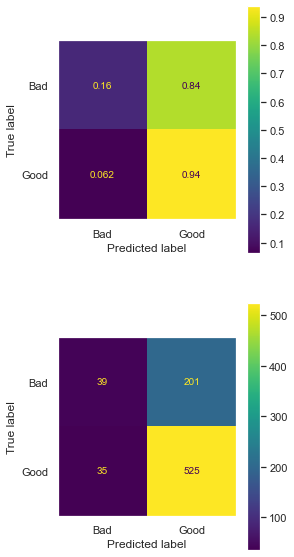

In [23]:
# Confusion matrix for the Logistic regression model
f, axs = plt.subplots(2, 1, figsize=(4, 10))
ConfusionMatrixDisplay.from_predictions(Y, lr_preds,
                                        display_labels=['Bad', 'Good'],
                                        normalize="true",
                                        ax=axs[0])
axs[0].grid()
ConfusionMatrixDisplay.from_predictions(Y, lr_preds,
                                        display_labels=['Bad', 'Good'],
                                        normalize=None,
                                        ax=axs[1])
axs[1].grid();

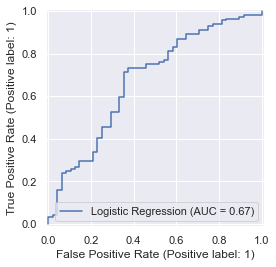

In [24]:
# Plot ROC AUC curve on the test set
f, axs = plt.subplots(1, 1, figsize=(5, 4))
RocCurveDisplay.from_estimator(rs_lr.best_estimator_, testX, testY, 
                               name="Logistic Regression",
                               ax=axs);

In [25]:
# Classification report for Logistic Regression
print(classification_report(Y, lr_preds, target_names=['Bad', 'Good']))

              precision    recall  f1-score   support

         Bad       0.53      0.16      0.25       240
        Good       0.72      0.94      0.82       560

    accuracy                           0.70       800
   macro avg       0.63      0.55      0.53       800
weighted avg       0.66      0.70      0.65       800



### Random Forest

In [35]:
%%time

# Specify model and subsequent hyperparameters to tune
rf = RandomForestClassifier(random_state=99)
parameters = {'n_estimators': randint(10, 200),  # Especifica un rango de enteros
              'max_depth': randint(2, 8),  # Especifica un rango de enteros para max_depth
              'min_samples_split': randint(2, 5),  # Especifica un rango de enteros
}

# Perform hyperparameter tuning with BayesSearchCV over 10 folds with AUC as refit metric.
gs_rf = RandomizedSearchCV(rf, parameters, cv=10, scoring=scoring, refit="auc", random_state=500, n_iter=10)

# Fit the BayesSearchCV object to the train data
gs_rf.fit(trainX, trainY)

# Run nested cross-validation over 10 folds
rf_scores = cross_validate(gs_rf, X, Y, cv=10, n_jobs=-1, verbose=1,
                           return_train_score=True, scoring=scoring)

# Make cross-validated predictions 
rf_preds = cross_val_predict(gs_rf, X, Y, cv=10, n_jobs=-1, verbose=3)

time.sleep(1)
for score in rf_scores:
        print(f"{score:<17}: {np.mean(rf_scores[score]):.2f}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  1.1min remaining:   28.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.5min finished


fit_time         : 32.29
score_time       : 0.03
test_auc         : 0.67
train_auc        : 0.90
test_specificity : 0.37
train_specificity: 0.54
test_recall      : 0.94
train_recall     : 0.99
test_accuracy    : 0.70
train_accuracy   : 0.80
CPU times: total: 21.4 s
Wall time: 3min 33s


In [28]:
from skopt.space import Real, Categorical, Integer

In [36]:
# Save best RF model
best_rf_model = gs_rf.best_estimator_
print(f"Best model: {gs_rf.best_estimator_}")
joblib.dump(best_rf_model, 'models/rf_model_pipeline.pkl')

Best model: RandomForestClassifier(max_depth=4, min_samples_split=3, n_estimators=27,
                       random_state=99)


['models/rf_model_pipeline.pkl']

In [37]:
%%bash

model="rf_model_pipeline.pkl"
sizeKB=$(du -k "models/$model" | cut -f 1)
echo Size for $model is $sizeKB kb

Size for rf_model_pipeline.pkl is 68 kb


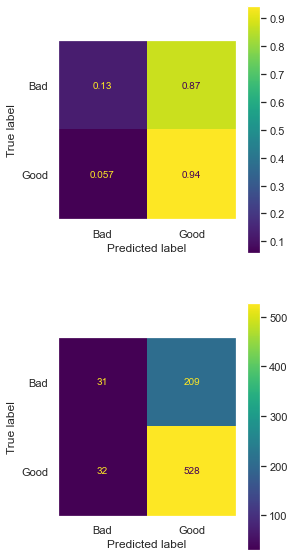

In [38]:
# Confusion matrix for Random Forest
f, axs = plt.subplots(2, 1, figsize=(4, 10))
ConfusionMatrixDisplay.from_predictions(Y, rf_preds,
                                        display_labels=['Bad', 'Good'],
                                        normalize="true",
                                        ax=axs[0])
axs[0].grid()
ConfusionMatrixDisplay.from_predictions(Y, rf_preds,
                                        display_labels=['Bad', 'Good'],
                                        normalize=None,
                                        ax=axs[1])
axs[1].grid();

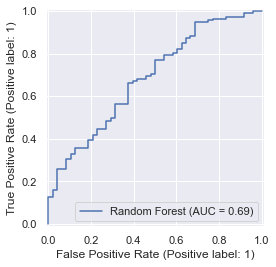

In [39]:
# Plot ROC AUC curve on the test set
f, axs = plt.subplots(1, 1, figsize=(5, 4))
RocCurveDisplay.from_estimator(gs_rf.best_estimator_, testX, testY, 
                               name="Random Forest",
                               ax=axs);

In [40]:
# Classification report for Random Forest
print(classification_report(Y, rf_preds, target_names=['Bad', 'Good']))

              precision    recall  f1-score   support

         Bad       0.49      0.13      0.20       240
        Good       0.72      0.94      0.81       560

    accuracy                           0.70       800
   macro avg       0.60      0.54      0.51       800
weighted avg       0.65      0.70      0.63       800



### LightGBM

In [42]:
%%time

# Specify model and subsequent hyperparameters to tune. There are many more parameters to choose from
lgbm = LGBMClassifier(random_state=99)
parameters = {'n_estimators': randint(10, 200),
              'max_depth': randint(2, 8),
              'num_leaves': randint(20, 60),
}

# Perform hyperparameter tuning with BayesSearchCV over 10 folds with AUC as refit metric.
# LightGBM is faster than RF so we can try more combinations (20 instead of 10)
gs_lgbm = RandomizedSearchCV(lgbm, parameters, cv=10, scoring=scoring, refit="auc", random_state=500, n_iter=10)

# Fit the BayesSearchCV object to the train data
gs_lgbm.fit(trainX, trainY)

# Run nested cross-validation over 10 folds
lgbm_scores = cross_validate(gs_lgbm, X, Y, cv=10, n_jobs=-1, verbose=1,
                           return_train_score=True, scoring=scoring)

# Make cross-validated predictions 
lgbm_preds = cross_val_predict(gs_lgbm, X, Y, cv=10, n_jobs=-1, verbose=3)

time.sleep(1)
for score in lgbm_scores:
        print(f"{score:<17}: {np.mean(lgbm_scores[score]):.2f}")

[LightGBM] [Info] Number of positive: 404, number of negative: 172
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001792 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 576, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.701389 -> initscore=0.853920
[LightGBM] [Info] Start training from score 0.853920
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Number of positive: 403, number of negative: 173
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 284
[LightGBM] [Info] Number of data points in the train set: 576, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.699653 -> initscore=0.845645
[LightGBM] [Info] Start training from score 0.845645
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[LightGBM] [Info] Number of positive: 403, number of negative: 173
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 576, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.699653 -> initscore=0.845645
[LightGBM] [Info] Start training from score 0.845645
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[LightGBM] [Info] Number of positive: 404, number of negative: 172
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 576, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.701389 -> initscore=0.853920
[LightGBM] [Info] Start training from score 0.853920
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Number of positive: 403, number of negative: 173
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 285
[LightGBM] [Info] Number of data points in the train set: 576, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.699653 -> initscore=0.845645
[LightGBM] [Info] Start training from score 0.845645
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[LightGBM] [Info] Number of positive: 403, number of negative: 173
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 576, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.699653 -> initscore=0.845645
[LightGBM] [Info] Start training from score 0.845645
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[LightGBM] [Info] Number of positive: 403, number of negative: 173
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 288
[LightGBM] [Info] Number of data points in the train set: 576, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.699653 -> initscore=0.845645
[LightGBM] [Info] Start training from score 0.845645
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[LightGBM] [Info] Number of positive: 403, number of negative: 173
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 288
[LightGBM] [Info] Number of data points in the train set: 576, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.699653 -> initscore=0.845645
[LightGBM] [Info] Start training from score 0.845645
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[LightGBM] [Info] Number of positive: 404, number of negative: 172
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 287
[LightGBM] [Info] Number of data points in the train set: 576, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.701389 -> initscore=0.853920
[LightGBM] [Info] Start training from score 0.853920
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[LightGBM] [Info] Number of positive: 403, number of negative: 173
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 576, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.699653 -> initscore=0.845645
[LightGBM] [Info] Start training from score 0.845645
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 403, number of negative: 173
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not 

[LightGBM] [Info] Number of positive: 403, number of negative: 173
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 288
[LightGBM] [Info] Number of data points in the train set: 576, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.699653 -> initscore=0.845645
[LightGBM] [Info] Start training from score 0.845645
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[LightGBM] [Info] Number of positive: 403, number of negative: 173
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 287
[LightGBM] [Info] Number of data points in the train set: 576, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.699653 -> initscore=0.845645
[LightGBM] [Info] Start training from score 0.845645
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[LightGBM] [Info] Number of positive: 403, number of negative: 173
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 285
[LightGBM] [Info] Number of data points in the train set: 576, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.699653 -> initscore=0.845645
[LightGBM] [Info] Start training from score 0.845645
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Number of positive: 403, number of negative: 173
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 287
[LightGBM] [Info] Number of data points in the train set: 576, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.699653 -> initscore=0.845645
[LightGBM] [Info] Start training from score 0.845645
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Number of positive: 403, number of negative: 173
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 288
[LightGBM] [Info] Number of data points in the train set: 576, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.699653 -> initscore=0.845645
[LightGBM] [Info] Start training from score 0.845645
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Number of positive: 404, number of negative: 172
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 576, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.701389 -> initscore=0.853920
[LightGBM] [Info] Start training from score 0.853920
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Number of positive: 403, number of negative: 173
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 576, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.699653 -> initscore=0.845645
[LightGBM] [Info] Start training from score 0.845645
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Number of positive: 404, number of negative: 172
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 576, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.701389 -> initscore=0.853920
[LightGBM] [Info] Start training from score 0.853920
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[LightGBM] [Info] Number of positive: 403, number of negative: 173
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 286
[LightGBM] [Info] Number of data points in the train set: 576, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.699653 -> initscore=0.845645
[LightGBM] [Info] Start training from score 0.845645
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[LightGBM] [Info] Number of positive: 403, number of negative: 173
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 288
[LightGBM] [Info] Number of data points in the train set: 576, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.699653 -> initscore=0.845645
[LightGBM] [Info] Start training from score 0.845645
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[LightGBM] [Info] Number of positive: 403, number of negative: 173
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 287
[LightGBM] [Info] Number of data points in the train set: 576, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.699653 -> initscore=0.845645
[LightGBM] [Info] Start training from score 0.845645
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   50.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   29.3s remaining:   12.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   40.2s finished


fit_time         : 15.76
score_time       : 0.02
test_auc         : 0.69
train_auc        : 0.91
test_specificity : 0.47
train_specificity: 0.65
test_recall      : 0.90
train_recall     : 0.97
test_accuracy    : 0.72
train_accuracy   : 0.83
CPU times: total: 12.3 s
Wall time: 1min 40s


In [43]:
# Save best LightGBM model
best_lgbm_model = gs_lgbm.best_estimator_
print(f"Best model: {gs_lgbm.best_estimator_}")
joblib.dump(best_lgbm_model, 'models/lgbm_model_pipeline.pkl')

Best model: LGBMClassifier(max_depth=2, n_estimators=81, num_leaves=33, random_state=99)


['models/lgbm_model_pipeline.pkl']

In [44]:
%%bash

model="lgbm_model_pipeline.pkl"
sizeKB=$(du -k "models/$model" | cut -f 1)
echo Size for $model is $sizeKB kb

Size for lgbm_model_pipeline.pkl is 48 kb


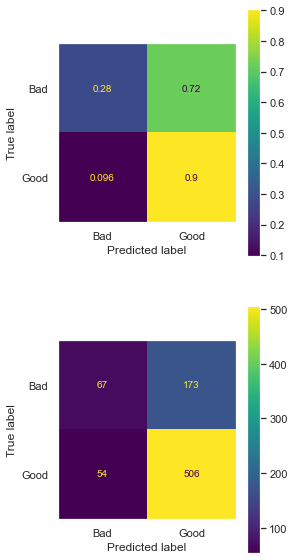

In [45]:
# Confusion matrix for LightGBM
f, axs = plt.subplots(2, 1, figsize=(4, 10))
ConfusionMatrixDisplay.from_predictions(Y, lgbm_preds,
                                        display_labels=['Bad', 'Good'],
                                        normalize="true",
                                        ax=axs[0])
axs[0].grid()
ConfusionMatrixDisplay.from_predictions(Y, lgbm_preds,
                                        display_labels=['Bad', 'Good'],
                                        normalize=None,
                                        ax=axs[1])
axs[1].grid();

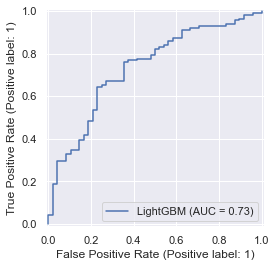

In [46]:
# Plot ROC AUC curve on the test set
f, axs = plt.subplots(1, 1, figsize=(5, 4))
RocCurveDisplay.from_estimator(gs_lgbm.best_estimator_, testX, testY, 
                               name="LightGBM",
                               ax=axs);

In [47]:
# Classification report for LightGBM
print(classification_report(Y, lgbm_preds, target_names=['Bad', 'Good']))

              precision    recall  f1-score   support

         Bad       0.55      0.28      0.37       240
        Good       0.75      0.90      0.82       560

    accuracy                           0.72       800
   macro avg       0.65      0.59      0.59       800
weighted avg       0.69      0.72      0.68       800



In [48]:
def get_results(df, score):
    """ Function for extracting train and test scores. """
    score = score.lower()
    return pd.DataFrame({f'train_{score}': df[f'train_{score}'],
                         f'test_{score}': df[f'test_{score}']})


def add_median_labels(ax, fmt='.2f'):
    """ Function for plotting the median on a boxplot.
        https://stackoverflow.com/questions/38649501/labeling-boxplot-in-seaborn-with-median-value
    """
    lines = ax.get_lines()
    boxes = [c for c in ax.get_children() if type(c).__name__ == 'PathPatch']
    lines_per_box = int(len(lines) / len(boxes))
    for median in lines[4:len(lines):lines_per_box]:
        x, y = (data.mean() for data in median.get_data())
        # choose value depending on horizontal or vertical plot orientation
        value = x if (median.get_xdata()[1] - median.get_xdata()[0]) == 0 else y
        text = ax.text(x, y, f'{value:{fmt}}', ha='center', va='center',
                       fontweight='bold', color='white')
        # create median-colored border around white text for contrast
        text.set_path_effects([
            path_effects.Stroke(linewidth=3, foreground=median.get_color()),
            path_effects.Normal(),
        ])

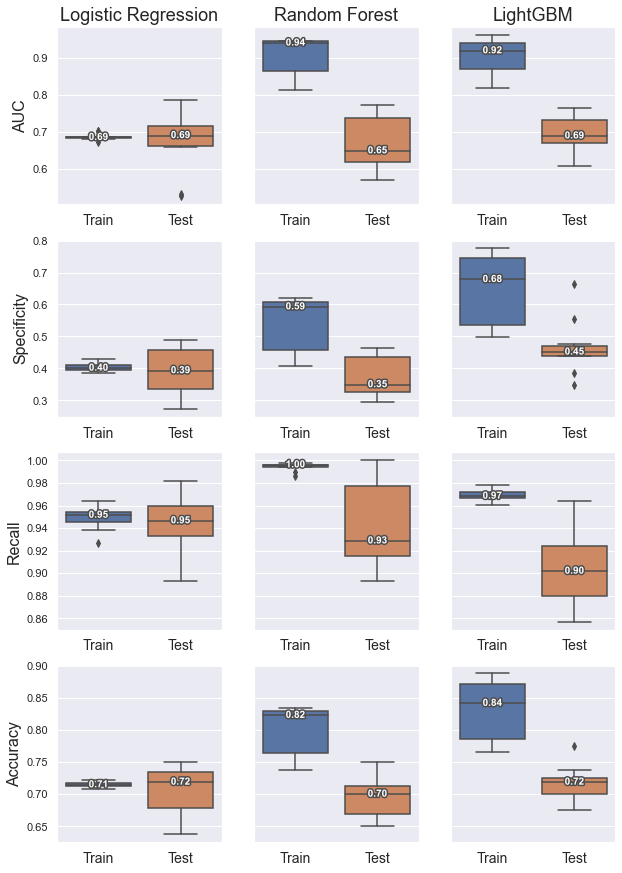

In [49]:
# Convert the scores to DataFrames
lr_scores = pd.DataFrame(lr_scores)
rf_scores = pd.DataFrame(rf_scores)
lgbm_scores = pd.DataFrame(lgbm_scores)

# Plot the train and test results by metric for the models. Share y-axis by metric
f, axs = plt.subplots(4, 3, figsize=(10, 15), sharey='row')

for i, name in enumerate(["AUC", "Specificity", "Recall", "Accuracy"]):
    # Logistic regression
    sns.boxplot(data=get_results(lr_scores, name), ax=axs[i][0])
    if i == 0: axs[i][0].set_title("Logistic Regression", size=18)
    axs[i][0].set_ylabel(name, size=16)
    axs[i][0].set_xticks([0, 1], ['Train', 'Test'], size=14)
    add_median_labels(axs[i][0])

    # Random Forest
    sns.boxplot(data=get_results(rf_scores, name), ax=axs[i][1])
    if i == 0: axs[i][1].set_title("Random Forest", size=18)
    axs[i][1].set_xticks([0, 1], ['Train', 'Test'], size=14)
    add_median_labels(axs[i][1])

    # LightGBM
    sns.boxplot(data=get_results(lgbm_scores, name), ax=axs[i][2])
    if i == 0: axs[i][2].set_title("LightGBM", size=18)
    axs[i][2].set_xticks([0, 1], ['Train', 'Test'], size=14)
    add_median_labels(axs[i][2]);
